In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import copy
from PIL import Image
import torch.nn.functional as F

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Path
DATA_PATH = 'natural_images' 

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 10
IMG_SIZE = 128  # Resizing images to 128x128
EPOCHS = 30

Using device: cuda


In [3]:
def show_samples(loader):
    xb, yb = next(iter(loader))
    grid = utils.make_grid(xb[:25], nrow=5, normalize=True, pad_value=0.8)

    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Örnekler")
    plt.show()

In [4]:
# 1. Define distinct transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomCrop(IMG_SIZE, padding=10),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.30, contrast=0.30, saturation=0.30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Load data cleanly first (no transforms yet if possible, or use a custom class)
# However, standard ImageFolder forces a transform. 
# The cleanest workaround for ImageFolder without custom classes is:

# Load the same folder twice with different settings
train_dataset = datasets.ImageFolder(root=DATA_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=DATA_PATH, transform=val_transform)
# Print classes detected
classes = train_dataset.classes
print(f"Classes detected: {classes}")

Classes detected: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [5]:
# 3. Manually split indices (this ensures no data leakage)
indices = torch.randperm(len(train_dataset)).tolist()
train_size = int(0.8 * len(train_dataset))

# Split into Train (80%) and Validation (20%)
# Create Subsets using the indices
train_subset = torch.utils.data.Subset(train_dataset, indices[:train_size])
val_subset = torch.utils.data.Subset(val_dataset, indices[train_size:])

# Create Data Loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Eğitim Örnek Sayısı {len(train_subset)}")
print(f"Test Örnek Sayısı {len(val_subset)}")

Eğitim Örnek Sayısı 5519
Test Örnek Sayısı 1380


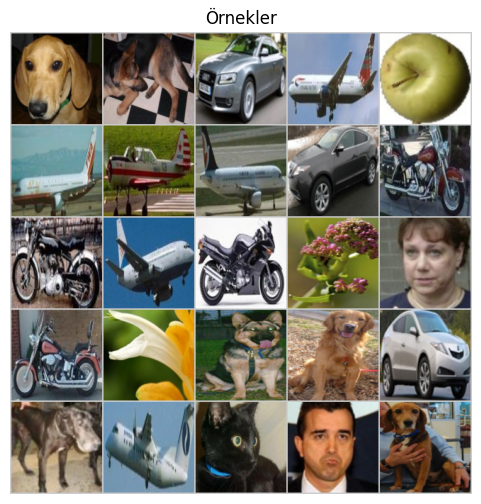

In [6]:
show_samples(train_loader)

In [7]:
# --- 3.  ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.fc_dropout = nn.Dropout(0.5) # Drop 50% of neurons randomly
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.cnn_dropout = nn.Dropout(0.25)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully Connected Layers
        # Calculation: Image is 128x128. 
        # After 3 MaxPools (dividing by 2 three times), size is 128 / 2 / 2 / 2 = 16.
        # So feature map is 16x16 with 64 channels.
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes) # Output layer (8 classes)

    def forward(self, x):
        # Pass through Conv blocks
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.cnn_dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        
        # Flatten for Dense layers
        x = x.view(-1, 64 * 16 * 16) 
        
        # Pass through Dense layers
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.fc2(x)
        return x

# Initialize Model
model = SimpleCNN(num_classes=len(classes)).to(device)
print(model)
# LOSS & OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

SimpleCNN(
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn_dropout): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
)


In [8]:
# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
val_accuracies = []

# --- EARLY STOPPING PARAMETERS ---
patience = 10              # How many epochs to wait before stopping if no improvement
min_delta = 0.001         # Minimum improvement required to reset the counter
early_stopping_counter = 0
best_val_loss = float('inf') # Initialize best loss to infinity
best_model_wts = copy.deepcopy(model.state_dict()) # To verify we keep the best weights

print("\nStarting Training...")
# Define a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(EPOCHS):
    # 1. TRAINING PHASE
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track Loss
        running_loss += loss.item()
        
        # Track Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    
    # 2. VALIDATION PHASE
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate test loss
            
            # Track Loss
            test_running_loss += loss.item()
            
            # Track Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # Calculate average loss and accuracy for this epoch
    avg_test_loss = test_running_loss / len(test_loader)
    val_acc = 100 * correct_test / total_test
    
    test_losses.append(avg_test_loss)
    val_accuracies.append(val_acc)

    scheduler.step() # upgrade the lr
    
    # 3. PRINT STATS
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_test_loss:.4f} | Val Acc: {val_acc:.2f}%")
    # 4. EARLY STOPPING CHECK
    # Check if the validation loss improved significantly
    if avg_test_loss < (best_val_loss - min_delta):
        print(f"  -> Validation Loss Improved ({best_val_loss:.4f} -> {avg_test_loss:.4f}). Saving model...")
        best_val_loss = avg_test_loss
        early_stopping_counter = 0 # Reset counter
        # Save the best model state
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'model_cnn.pth')
    else:
        early_stopping_counter += 1
        print(f"  -> No improvement. Early Stopping Counter: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("\nEarly Stopping Triggered! Stopping training.")
        # Load the best weights back into the model
        model.load_state_dict(best_model_wts)
        break

print("Training Complete!")


Starting Training...
Epoch [1/30] Train Loss: 1.2662 | Train Acc: 55.97% | Val Loss: 0.8263 | Val Acc: 71.23%
  -> Validation Loss Improved (inf -> 0.8263). Saving model...
Epoch [2/30] Train Loss: 0.6952 | Train Acc: 75.77% | Val Loss: 0.6030 | Val Acc: 78.84%
  -> Validation Loss Improved (0.8263 -> 0.6030). Saving model...
Epoch [3/30] Train Loss: 0.5387 | Train Acc: 80.47% | Val Loss: 0.4961 | Val Acc: 82.32%
  -> Validation Loss Improved (0.6030 -> 0.4961). Saving model...
Epoch [4/30] Train Loss: 0.4628 | Train Acc: 83.40% | Val Loss: 0.4449 | Val Acc: 84.20%
  -> Validation Loss Improved (0.4961 -> 0.4449). Saving model...
Epoch [5/30] Train Loss: 0.3976 | Train Acc: 85.25% | Val Loss: 0.3883 | Val Acc: 85.72%
  -> Validation Loss Improved (0.4449 -> 0.3883). Saving model...
Epoch [6/30] Train Loss: 0.3516 | Train Acc: 87.15% | Val Loss: 0.3621 | Val Acc: 86.88%
  -> Validation Loss Improved (0.3883 -> 0.3621). Saving model...
Epoch [7/30] Train Loss: 0.3320 | Train Acc: 88.11%

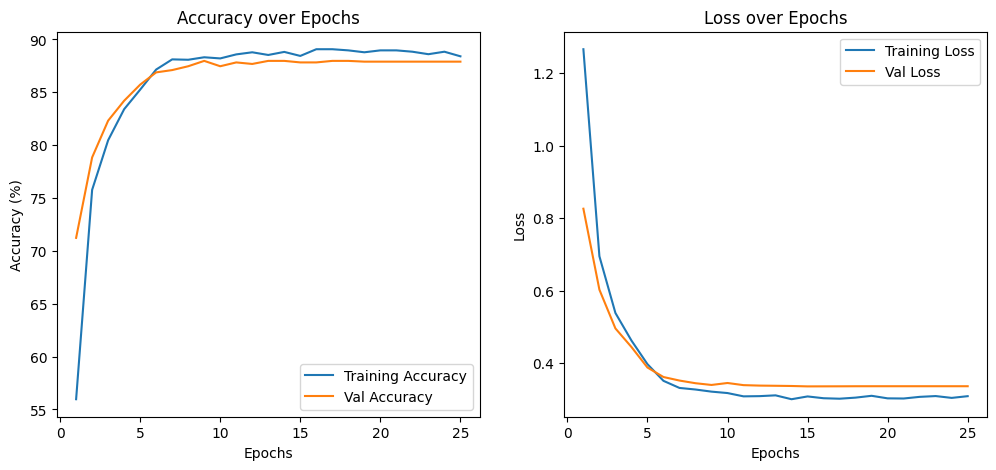

In [9]:
epochs_range = range(1, 25 + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.88      0.91       139
         car       0.93      0.96      0.95       200
         cat       0.72      0.75      0.73       209
         dog       0.59      0.52      0.55       138
      flower       0.90      0.87      0.89       180
       fruit       0.99      1.00      1.00       172
   motorbike       0.96      1.00      0.98       170
      person       0.94      0.99      0.97       172

    accuracy                           0.88      1380
   macro avg       0.87      0.87      0.87      1380
weighted avg       0.88      0.88      0.88      1380



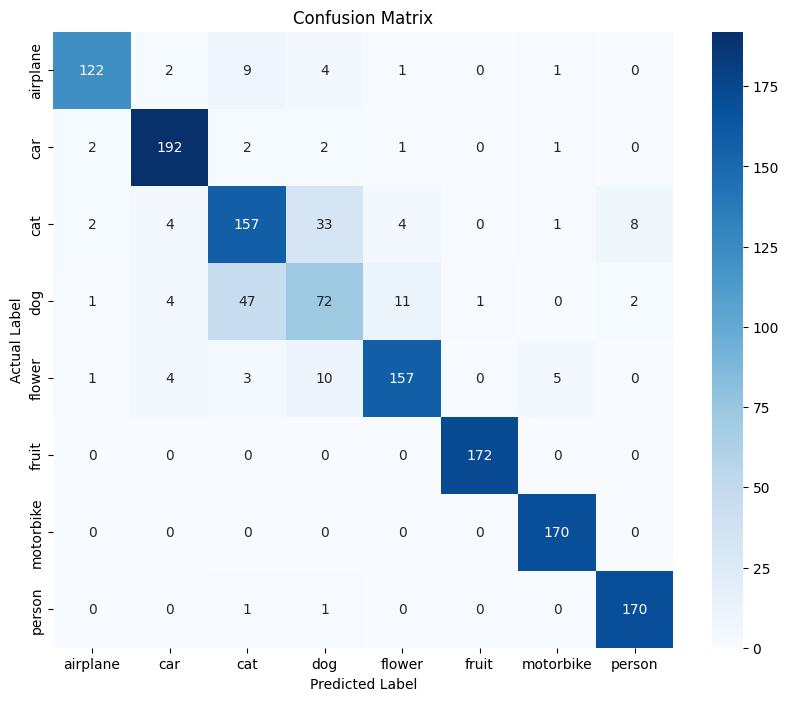

In [10]:
# 1. Collect all predictions and true labels
y_pred = []
y_true = []

model.eval() # Ensure dropout is OFF
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy for sklearn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Ensure class names matches your dataset order
class_names = train_subset.dataset.classes 

# --- 2. Print Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 3. Plot Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

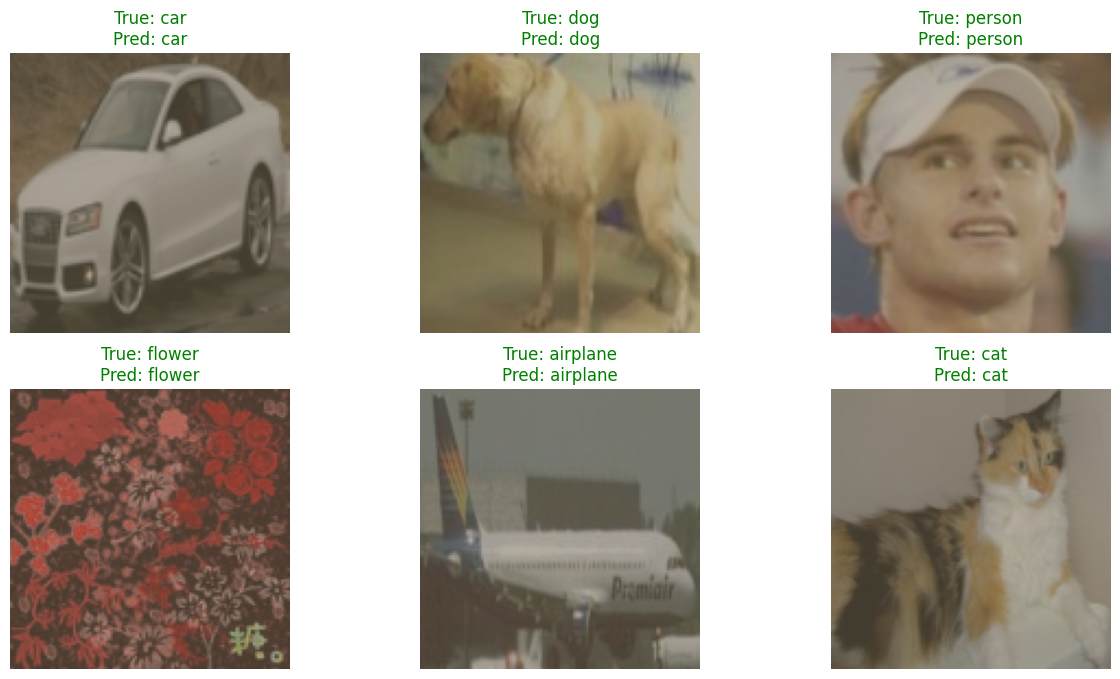

In [23]:
# Visualization Function (Validation Data) ---
def visualize_cnn_predictions(model, loader, class_names, num_images=6):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        # Denormalize (assuming mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        true_lbl = class_names[labels[i]]
        pred_lbl = class_names[preds[i]]
        color = 'green' if true_lbl == pred_lbl else 'red'
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color)
        plt.axis("off")
    plt.show()

# Run visualization (CNN)
visualize_cnn_predictions(model, test_loader, class_names)

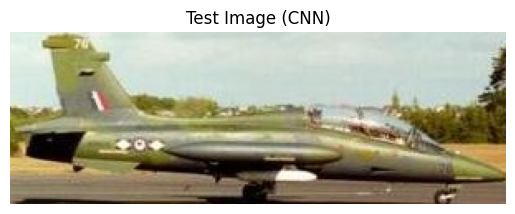

CNN Prediction: airplane
Confidence: 98.87%


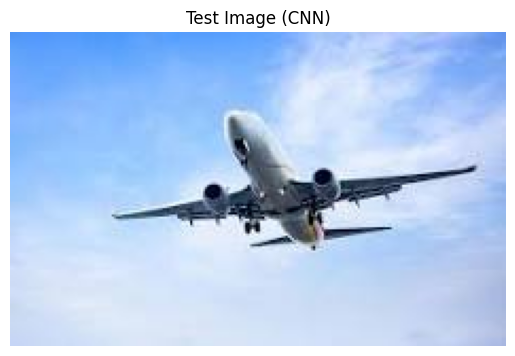

CNN Prediction: airplane
Confidence: 43.73%


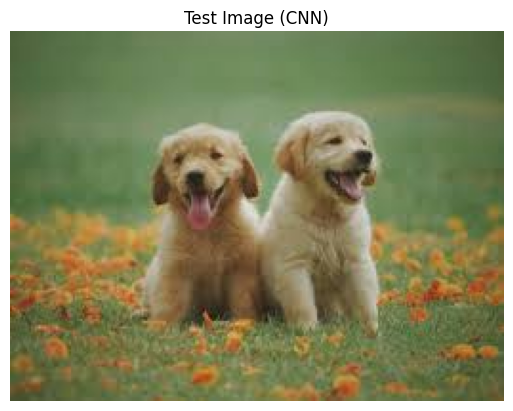

CNN Prediction: airplane
Confidence: 45.49%


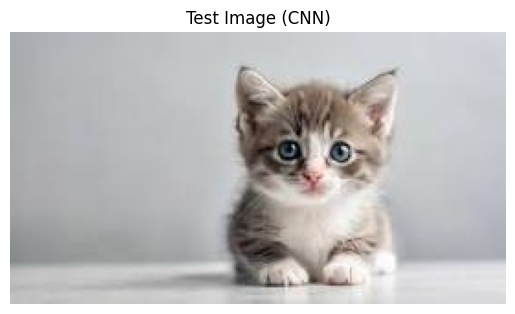

CNN Prediction: cat
Confidence: 61.78%


In [41]:
# Test on External Image (CNN) ---
def predict_cnn_image(image_path, model_path, class_names):
    # 1. Define Transforms (Same as training)
    transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    
    # 2. Load Model
    model = SimpleCNN(num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # 3. Predict
    try:
        image = Image.open(image_path).convert('RGB')
        plt.imshow(image)
        plt.axis('off')
        plt.title("Test Image (CNN)")
        plt.show()
        
        input_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probs, 1)
            
        print(f"CNN Prediction: {class_names[pred_idx.item()]}")
        print(f"Confidence: {conf.item()*100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")
        
predict_cnn_image('natural_images/airplane/airplane_0000.jpg', 'model_cnn.pth', class_names)
predict_cnn_image('airplane.jpg', 'model_cnn.pth', class_names)
predict_cnn_image('dog.jpg', 'model_cnn.pth', class_names)
predict_cnn_image('cat.jpg', 'model_cnn.pth', class_names)

In [11]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        
        # --- 1. CNN LAYERS (Feature Extractor) ---
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.cnn_dropout = nn.Dropout(0.25)
        
        # --- 2. LSTM LAYER ---
        # Calculation for LSTM Input:
        # Image input: 128x128
        # After 3 pools (div by 8): Feature map is 16x16
        # Channels: 64
        # We treat 'Height' (16) as the Sequence Length (Time steps)
        # We treat 'Width * Channels' (16 * 64 = 1024) as the Input Features per step
        
        self.lstm_input_size = 16 * 64 # 1024
        self.lstm_hidden_size = 256
        
        # batch_first=True means input format is (Batch, Seq, Feature)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, 
                            hidden_size=self.lstm_hidden_size,
                            # bidirectional=True,
                            num_layers=2,
                            dropout=0.4,
                            batch_first=True)
        
        # --- 3. CLASSIFIER ---
        self.fc = nn.Linear(self.lstm_hidden_size, num_classes)

    def forward(self, x):
        # 1. CNN Forward Pass
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.cnn_dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        
        # Current Shape: (Batch, 64, 16, 16) [C, H, W]
        
        # 2. Reshape for LSTM
        # We want (Batch, Sequence, Features) -> (Batch, 16, 1024)
        
        # Permute to put Height (Sequence) first: (Batch, Height, Width, Channels)
        x = x.permute(0, 2, 3, 1) 
        
        # Merge Width and Channels into one dimension
        # (Batch, 16, 16, 64) -> (Batch, 16, 1024)
        x = x.reshape(x.size(0), 16, -1)
        
        # 3. LSTM Forward Pass
        # out shape: (Batch, Seq_Len, Hidden_Size)
        # _ (hidden states): not needed here
        out, _ = self.lstm(x)
        
        # 4. Take the last time step
        # We only care about the LSTM's final conclusion after seeing all rows
        out = out[:, -1, :] 
        # 4. Global Average Pooling (The Fix)
        # Instead of taking just the last row, we average ALL rows.
        # This helps the model remember features from the top of the image too.
        # out = torch.mean(out, dim=1)
        
        # 5. Classifier
        out = self.fc(out)
        return out

cnn_lstm_model = CNNLSTM(num_classes=len(classes)).to(device)
print(cnn_lstm_model)
# criterion, optimizer
criterion_cnn_lstm = nn.CrossEntropyLoss()
optimizer_cnn_lstm = optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)

CNNLSTM(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(1024, 256, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)


In [12]:
# Lists to store metrics for plotting
train_losses_cnn_lstm = []
train_accuracies_cnn_lstm = []
test_losses_cnn_lstm = []
val_accuracies_cnn_lstm = []

# --- EARLY STOPPING PARAMETERS ---
patience = 5              # How many epochs to wait before stopping if no improvement
min_delta = 0.001         # Minimum improvement required to reset the counter
early_stopping_counter = 0
best_val_loss = float('inf') # Initialize best loss to infinity
best_model_wts = copy.deepcopy(cnn_lstm_model.state_dict()) # To verify we keep the best weights

print("\nStarting Training with Early Stopping...")
# Define a scheduler
scheduler_cnn_lstm = torch.optim.lr_scheduler.StepLR(optimizer_cnn_lstm, step_size=5, gamma=0.1)

for epoch in range(EPOCHS):
    # 1. TRAINING PHASE
    cnn_lstm_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = cnn_lstm_model(images)
        loss = criterion_cnn_lstm(outputs, labels)
        
        # Backward pass and optimization
        optimizer_cnn_lstm.zero_grad()
        loss.backward()
        optimizer_cnn_lstm.step()
        
        # Track Loss
        running_loss += loss.item()
        
        # Track Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    train_losses_cnn_lstm.append(avg_train_loss)
    train_accuracies_cnn_lstm.append(train_acc)
    
    # 2. VALIDATION PHASE
    cnn_lstm_model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_lstm_model(images)
            loss = criterion_cnn_lstm(outputs, labels) # Calculate test loss
            
            # Track Loss
            test_running_loss += loss.item()
            
            # Track Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # Calculate average loss and accuracy for this epoch
    avg_test_loss = test_running_loss / len(test_loader)
    val_acc = 100 * correct_test / total_test
    
    test_losses_cnn_lstm.append(avg_test_loss)
    val_accuracies_cnn_lstm.append(val_acc)

    scheduler_cnn_lstm.step() # upgrade the lr
    
    # 3. PRINT STATS
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_test_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # 4. EARLY STOPPING CHECK
    # Check if the validation loss improved significantly
    if avg_test_loss < (best_val_loss - min_delta):
        print(f"  -> Validation Loss Improved ({best_val_loss:.4f} -> {avg_test_loss:.4f}). Saving model...")
        best_val_loss = avg_test_loss
        early_stopping_counter = 0 # Reset counter
        # Save the best model state
        best_model_wts = copy.deepcopy(cnn_lstm_model.state_dict())
        torch.save(cnn_lstm_model.state_dict(), 'best_cnn_lstm_model.pth')
    else:
        early_stopping_counter += 1
        print(f"  -> No improvement. Early Stopping Counter: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("\nEarly Stopping Triggered! Stopping training.")
        # Load the best weights back into the model
        cnn_lstm_model.load_state_dict(best_model_wts)
        break

print("Training Complete!")


Starting Training with Early Stopping...
Epoch [1/30] Train Loss: 1.5869 | Train Acc: 41.95% | Val Loss: 1.1522 | Val Acc: 58.84%
  -> Validation Loss Improved (inf -> 1.1522). Saving model...
Epoch [2/30] Train Loss: 0.8695 | Train Acc: 68.91% | Val Loss: 0.7994 | Val Acc: 70.29%
  -> Validation Loss Improved (1.1522 -> 0.7994). Saving model...
Epoch [3/30] Train Loss: 0.6605 | Train Acc: 75.92% | Val Loss: 0.6876 | Val Acc: 73.04%
  -> Validation Loss Improved (0.7994 -> 0.6876). Saving model...
Epoch [4/30] Train Loss: 0.5438 | Train Acc: 79.83% | Val Loss: 0.6857 | Val Acc: 73.84%
  -> Validation Loss Improved (0.6876 -> 0.6857). Saving model...
Epoch [5/30] Train Loss: 0.4727 | Train Acc: 82.53% | Val Loss: 0.6336 | Val Acc: 76.59%
  -> Validation Loss Improved (0.6857 -> 0.6336). Saving model...
Epoch [6/30] Train Loss: 0.3912 | Train Acc: 85.87% | Val Loss: 0.5086 | Val Acc: 80.80%
  -> Validation Loss Improved (0.6336 -> 0.5086). Saving model...
Epoch [7/30] Train Loss: 0.3744

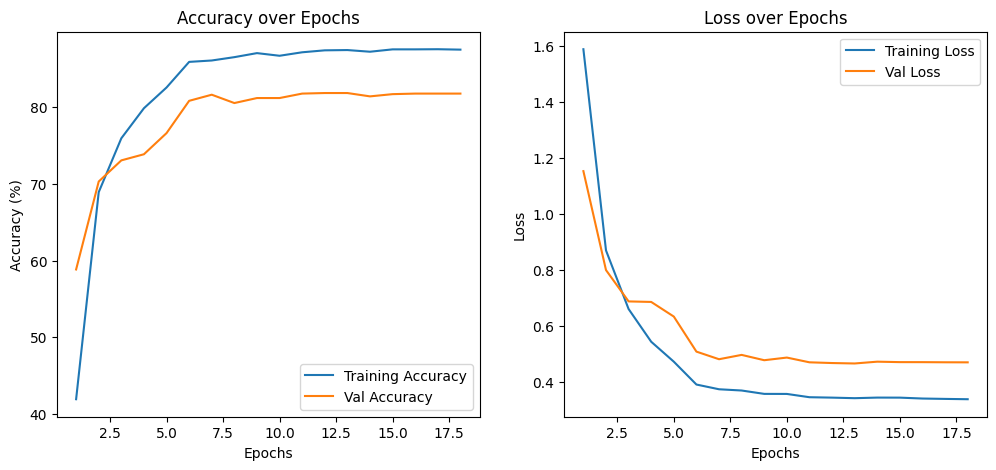

In [14]:
epochs_range = range(1, 18 + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies_cnn_lstm, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies_cnn_lstm, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses_cnn_lstm, label='Training Loss')
plt.plot(epochs_range, test_losses_cnn_lstm, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.89      0.87       139
         car       0.93      0.85      0.89       200
         cat       0.59      0.76      0.66       209
         dog       0.55      0.33      0.42       138
      flower       0.89      0.76      0.82       180
       fruit       0.99      1.00      0.99       172
   motorbike       0.96      0.94      0.95       170
      person       0.80      0.95      0.87       172

    accuracy                           0.82      1380
   macro avg       0.82      0.81      0.81      1380
weighted avg       0.82      0.82      0.81      1380



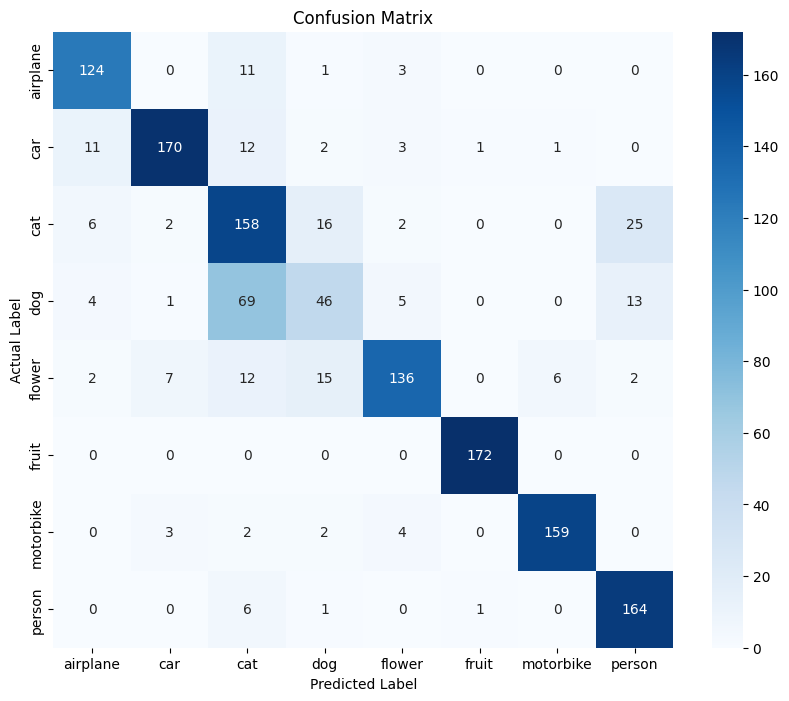

In [15]:
# 1. Collect all predictions and true labels
y_pred = []
y_true = []

cnn_lstm_model.eval() # Ensure dropout is OFF
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy for sklearn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Ensure class names matches your dataset order
class_names = train_subset.dataset.classes 

# --- 2. Print Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 3. Plot Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

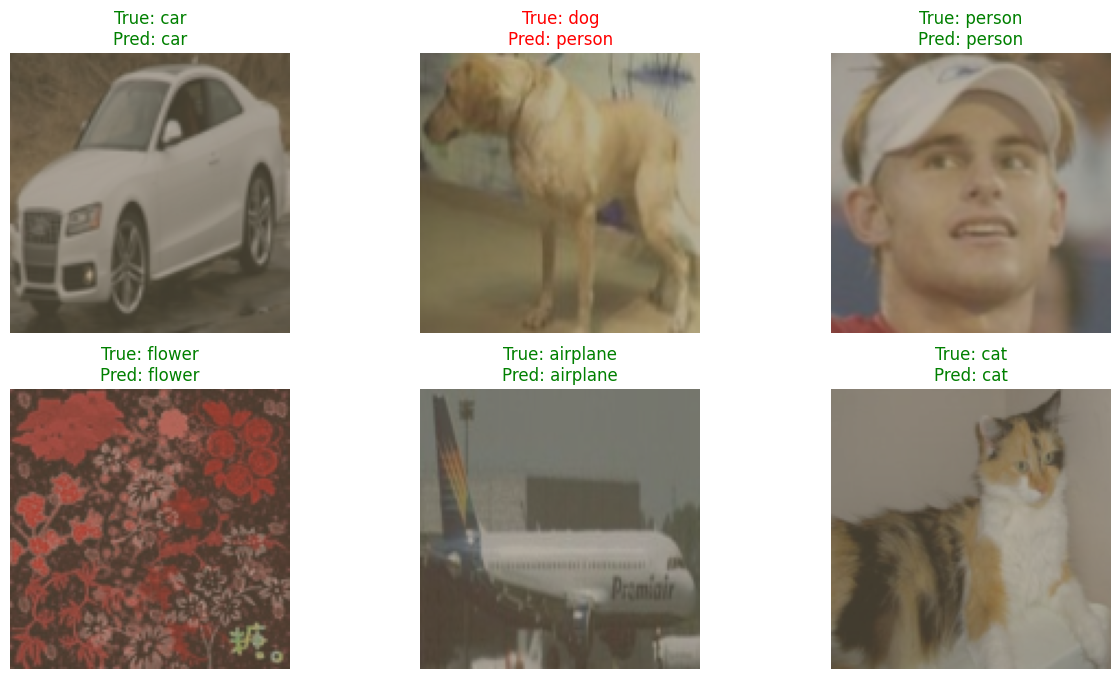

In [18]:
# Visualization Function (Validation Data) ---
def visualize_cnnlstm_predictions(model, loader, class_names, num_images=6):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        true_lbl = class_names[labels[i]]
        pred_lbl = class_names[preds[i]]
        color = 'green' if true_lbl == pred_lbl else 'red'
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color)
        plt.axis("off")
    plt.show()

# Run visualization (CNN-LSTM)
visualize_cnnlstm_predictions(cnn_lstm_model, test_loader, class_names)

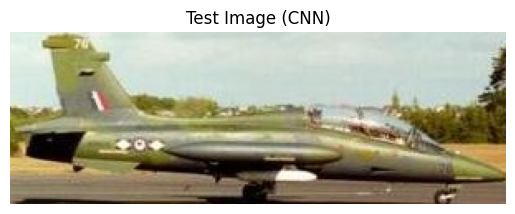

CNN-LSTM Prediction: airplane
Confidence: 98.75%


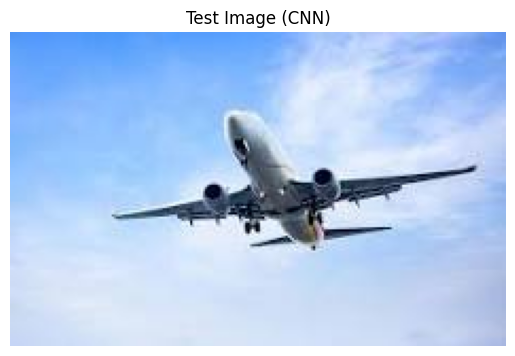

CNN-LSTM Prediction: airplane
Confidence: 88.12%


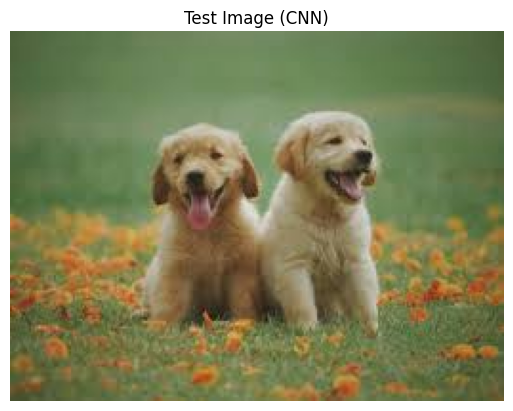

CNN-LSTM Prediction: cat
Confidence: 43.67%


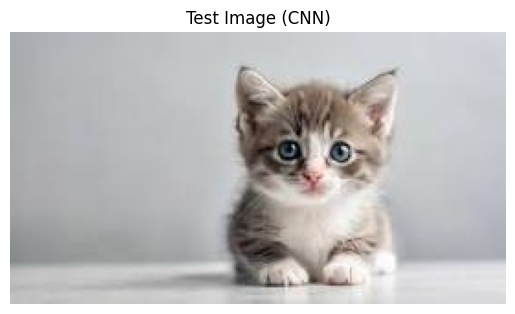

CNN-LSTM Prediction: dog
Confidence: 46.47%


In [42]:
# Test on External Image (CNN-LSTM) ---
def predict_cnnlstm_image(image_path, model_path, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Transforms
    transform = transforms.transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    
    # 2. Load Model
    model = CNNLSTM(num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # 3. Predict
    try:
        image = Image.open(image_path).convert('RGB')
        plt.imshow(image)
        plt.axis('off')
        plt.title("Test Image (CNN)")
        plt.show()
        
        input_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probs, 1)
            
        print(f"CNN-LSTM Prediction: {class_names[pred_idx.item()]}")
        print(f"Confidence: {conf.item()*100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")

predict_cnnlstm_image('natural_images/airplane/airplane_0000.jpg', 'best_cnn_lstm_model.pth', class_names)
predict_cnnlstm_image('airplane.jpg', 'best_cnn_lstm_model.pth', class_names)
predict_cnnlstm_image('dog.jpg', 'best_cnn_lstm_model.pth', class_names)
predict_cnnlstm_image('cat.jpg', 'best_cnn_lstm_model.pth', class_names)